In [582]:
# read in data from excel file to dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
from scipy.stats import t

#===================== Independent Constants =====================
class EnvConstants:
    """Environmental constants for atmospheric and crop conditions with units and descriptions.

    Attributes:
        P (float): Atmospheric pressure (kPa).
        k (float): von Karman's constant (none).
        esurface (float): Emissivity of crop (none).
        sigma (float): Stefan-Boltzmann constant (W m-2 K-4).
        KR (int): Parameter in Equ (24.2) (W m-2).
        KD1 (float): Parameter in Equ (24.6) (kPa-1).
        KD2 (float): Parameter in Equ (24.6) (kPa-2).
        TL (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        T0 (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        TH (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        KM2 (float): Parameter in Equ (24.6) (mm-1).
        rho_a (float): Moist Air density (kg m-3).
        cp (float): Specific heat capacity of air at constant pressure (J kg-1 K-1).
        gc (float): Canopy cover factor (none).
        aT (float): Parameter in temperature stress factor (none).
    """
    P: float = 101.20  # Atmospheric pressure (kPa)
    k: float = 0.4  # von Karman's constant
    esurface: float = 0.95  # Emissivity of crop 
    sigma: float = 5.67E-08  # Stefan-Boltzmann constant (W m-2 K-4)
    KR: int = 200  # Parameter in Equ (24.2)
    KD1: float = -0.307  # Parameter in Equ (24.6)
    KD2: float = 0.019  # Parameter in Equ (24.6)
    TL: float = 273.00  # Parameter in Equ (24.4) and Equ (24.5)
    T0: float = 293.00  # Parameter in Equ (24.4) and Equ (24.5)
    TH: float = 313.00  # Parameter in Equ (24.4) and Equ (24.5)
    KM2: float = -0.10  # Parameter in Equ (24.6)
    rho_a: float = 1.23  # Moist Air density
    cp: float = 1013.00  # Specific heat capacity of air
    gc: float = 1.00  # Canopy cover factor
    aT: float = 1.00  # Parameter in temperature stress factor

#===================== Crop Dependent Constants =====================

class ForestConstants:
    """Forest environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        zm (float): Aerodynamic roughness of crop (m).
        KM1 (float): Parameter in Equ (24.6) (none).
    """
    LAI: float = 4.00  # Leaf Area Index
    h: float = 20.00  # Canopy Height
    a: float = 0.12  # Albedo
    g0: float = 15.00  # Canopy Specific Constant
    SMo: float = 40.00  # Maximum soil moisture accessible to roots
    SMinit: float = 40.00  # Initial Root-accessible soil moisture
    S: float = 4.00  # Maximum Canopy Water Storage
    zm: float = 22  # Aerodynamic roughness of crop
    LW_up_init: float = -350.00  # Initial upward longwave radiation (W m-2)
    KM1: float = 3.36E-04  # Parameter in Equ (24.6)
    d: float = np.NaN  # Zero plane displacement height
    z0: float = np.NaN  # Aerodynamic roughness of crop

class GrassConstants:
    """Grass environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        zm (float): Aerodynamic roughness of crop (m).
    """
    LAI: float = 2.00  # Leaf Area Index
    h: float = 0.12  # Canopy Height
    a: float = 0.23  # Albedo
    g0: float = 30.00  # Canopy Specific Constant
    SMo: float = 40.00  # Maximum soil moisture accessible to roots
    SMinit: float = 40.00  # Initial Root-accessible soil moisture
    S: float = 2.00  # Maximum Canopy Water Storage
    zm: float = 2  # Aerodynamic roughness of crop
    LW_up_init: float = -319.00  # Initial upward longwave radiation (W m-2)
    KM1: float = 1.87E-02  # Parameter in Equ (24.6)
    d: float = np.NaN  # Zero plane displacement height
    z0: float = np.NaN  # Aerodynamic roughness of crop

#==================== Model forcing data ==========================
excel_file = "Lab1.xlsx"
# Read the data from the Excel file, skipping rows so that headers start from row 11 (indexing starts from 0)
forest_data = pd.read_excel(excel_file, header=0, sheet_name = "Forest", skiprows=10)
grass_data = pd.read_excel(excel_file, sheet_name="Grass", header=0, skiprows=10) 


c:\Users\adunw\miniconda3\envs\EcoHydro\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\adunw\miniconda3\envs\EcoHydro\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [583]:
# Part A: Aerodynamic Parameterization. 

def calc_d(h, LAI):
    """
    Calculate zero plane displacement height using constants from either ForestConstants or Grasscrop_constants.
    (TH Eq 22.2)
    :param h: Canopy height (m). Crop constant.
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Zero plane displacement height (m).
    """
    return 1.1 * h * np.log(1 + (LAI / 5)**0.25)  # TH Eq 22.2

def calc_zo(h, d):
    """
    Calculate aerodynamic roughness of crop. (TH Eq 22.3, 22.4) 
    :param h: Canopy height (m). Crop constant.
    :param d: Zero plane displacement height (m).
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Aerodynamic roughness of crop (m).
    """

    return 0.3 * h * (1 - d / h)  # TH Eq 22.4



In [584]:
# Part B: Surface Resistance Parameterization


def calc_rs(gs):
    """
    Calculate total surface resistance (Eq. 24.1 in TH)
    :param gs: Total surface conductance (mm s-1).
    :return: Total surface resistance (s mm-1).
    """
    rs = 1 / gs # Eq. 24.1 TH
    rs *= 10**3  # convert to s m-1
    return min(rs, 10**6)  
    
def calc_esat(T):
    """
    Calculate saturation vapor pressure from temperature (Eq. 2.17 in TH)
    :param T: Temperature (C).
    :return: Saturation vapor pressure (kPa).
    """
    esat = 0.6108 * np.exp(17.27 * T / (T + 237.3)) # Eq. 2.17 TH
    return esat

def calc_e(q):
    """
    Calculate vapor pressure from specific humidity and pressure (Eq. 2.9 in TH)
    :param q: Specific humidity (kg kg-1).
    :param P: Atmospheric pressure (kPa). Environemntal constant.
    :return: Vapor pressure (kPa).
    """
    P = EnvConstants.P
    e = P * q / 0.622 # Eq 2.9 TH
    return e

def calc_D(esat, e):
    """
    Calculate vapor pressure deficit (Eq. 2.10 in TH)
    :param esat: Saturation vapor pressure (kPa).
    :param e: Vapor pressure (kPa).
    :return: Vapor pressure deficit (kPa).
    """
    D = esat - e # Eq 2.10 TH
    return D


In [585]:
#Part C: Radiation Parameterization

def calc_Ts(Ta, H, ra):
    """
    Calculate surface temperature (Eq. 21.30 in TH)
    :param Ta: Air temperature (K).
    :param H: Sensible heat flux (W m-2).
    :param ra: Aerodynamic resistance (s m-1).
    :param rho_a: Moist Air density (kg m-3). Environmental Constant.
    :param cp: Specific heat capacity of air (J kg-1 K-1). Environmental Constant.
    :return: Surface temperature (K).
    """
    cp = EnvConstants.cp
    rho_a = EnvConstants.rho_a
    Ts = Ta + (H *ra / rho_a / cp) # Eq 21.30 TH
    return Ts

def calc_LW_up(Ts_1, Ts_2):
    """
    Calculate long wave radiation from surface temperature and emissivity. (Eq 5.19 in TH)
    :param T_s: Surface temperature (K).
    :param emissivity: Emissivity of crop (none). Environmental constant.
    :param sigma: Stefan-Boltzmann constant (W m-2 K-4). Environmental constant.
    :return: Long wave radiation from surface (W m-2).
    """
    sigma = EnvConstants.sigma
    emissivity = EnvConstants.esurface
    LW_up = - emissivity * sigma * (Ts_1**4 + Ts_2**4)/2 # Modified Eq 5.19 TH (Problem statement C.2)
    return LW_up

def calc_Rn(SW_in, a, LW_up, LW_down):
    """
    Calculate net radiation (Eq 5.28 in TH)
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param a: Albedo (none). Crop Constant.
    :param LW_up: Long wave radiation from surface (W m-2).
    :param LW_down: Long wave radiation from atmosphere (W m-2).
    :return: Net radiation (W m-2).
    """
    LW_net = LW_down + LW_up
    Rn = (1 - a) * SW_in + LW_net # Eq 5.28 TH
    return Rn

In [586]:


#Part D.1 Canopy Water Balance Parameterization (Includes Interception) 

def calc_delta(T, e_sat): 
    """
    Calculate gradient of the saturation vapor pressure curve from saturation vapor pressure and temperature
    (Eq 2.18 in TH)
    e_sat: saturation vapor pressure in kPa
    T: temperature in degrees Celsius
    return: slope of the saturation vapor pressure curve in kPa/°C
    """

    delta = 4098 * e_sat / (T + 237.3)**2 # Eq 2.18 TH, problem statement D.1.1
    return delta

def calc_LH(T):
    """
    Calculate latent heat of vaporization from temperature (Eq 2.1 in TH)
    T: temperature in degrees Celsius
    return: latent heat of vaporization (lambda) in J/kg
    """
    LH = (2.501 - 0.002361 * T )* 10**6 # Eq 2.1 TH, problem statement D.1.1
    return LH

def calc_psy_const(LH):
    """
    Calculate psychrometric constant (Eq 2.25 in TH)
    c_p: specific heat of dry air at constant pressure in J/kg/K
    P: pressure in kPa
    LH: latent heat of vaporization in J/kg
    return: psychrometric constant in kPa/°C
    """
    cp = EnvConstants.cp # Specific heat capacity of air at constant pressure in J/kg/K
    P = EnvConstants.P
    psychrometric_constant = cp * P / (0.622 * LH) # Eq. 2.25 TH, problem statement D.1.1
    return psychrometric_constant


def calc_lambdaET(delta, Rn, D, psy_const, rs, ra):
    """
    Calculate transpiration rate (Eq 22.18 in TH)
    :param delta: slope of the saturation vapor pressure curve in kPa/°C
    :param Rn: net radiation in W/m^2
    :param D: vapor pressure deficit in kPa
    :param psy_const: psychrometric constant in kPa/°C
    :param ra: aerodynamic resistance in s/m
    return: transpiration rate in W m-2
    """
    A = Rn # Available energy = net radiation problem statement D.1.8
    Dref = D # VPD at reference level above canopy in kPa
    rho_a = EnvConstants.rho_a
    cp = EnvConstants.cp
    lambdaET = (delta * A + (rho_a * cp * Dref / ra) ) / (delta + psy_const * (1 + rs / ra)) # Eq 22.18 TH, problem statement D.1.5
    return lambdaET




In [587]:

def calc_ra_FAO(um):
    """
    Calculate aerodynamic resistance using wind speed
    :param um: Wind speed at measurement height (m s-1).
    """
    ra = 208 / um
    return ra

def calc_ETa_FAO(PET, SM, SM0):
    """
    Calculate actual evapotranspiration using soil moisture (Eq 23.17 in TH)
    :param PET: reference evapotranspiration in mm/day
    :param SM: soil moisture in mm
    :param SM0: soil moisture at field capacity in mm
    return: actual evapotranspiration in mm/day
    """
    ETa = PET * (SM / SM0) # Eq 23.17 TH
    return ETa

In [588]:
def setup_df(file_name):
    # read first 9 columns of csv file that has a header
    data = pd.read_csv(file_name)
    return data

def run_FAO_model(data, crop_constants):
    
    rs  = 70 # s/m

    data['Tk'] = data['Ta'] + 273.17 # Convert temperature from Celsius to Kelvin
    data['ra'] = calc_ra_FAO(data['um']) # A.2
    
    # Part B: Surface Resistance Parameterization
    data['esat(T)'] = calc_esat(data['Ta']) 
    data['e'] = calc_e(data['q'])
    data['D'] = calc_D(data['esat(T)'], data['e'])

    # D.1 Canopy Water Balance Parameterization
    data['delta'] = calc_delta(data['Ta'], data['esat(T)']) #D.1.1
    data['LH'] = calc_LH(data['Ta']) #D.1.1
    data['psy_const'] = calc_psy_const(data['LH']) #D.1.1

    for index in range(len(data)):
        # Current values for the row
        SM0 = crop_constants.SMo
        delta = data.at[index, 'delta']
        psy_const = data.at[index, 'psy_const']
        SM = data.at[index, 'SM']
        D = data.at[index, 'D']
        Rn = data.at[index, 'Rn']
        ra = data.at[index, 'ra']

        PET_W_m2 = calc_lambdaET(delta, Rn, D, psy_const, rs, ra)
        PET_mm = PET_W_m2 * 3.5 /100 # Convert from W m-2 to mm day-1
        ETa = calc_ETa_FAO(PET_mm, SM, SM0)
        data.at[index, 'PET (mm)'] = PET_mm
        data.at[index, 'lambdaETa Typ Hydro (mm)'] = ETa
    
    data.to_csv('FAO_processed_grass_data.csv', index=False)
    return data


forcing_data = r"midterm_forcing_data_grass.csv"
grass_constants = GrassConstants()
grass_constants.SMo = 40
grass_constants.SMinit = 40
grass_data = setup_df(forcing_data)
grass_data = run_FAO_model(grass_data, grass_constants)

forcing_data = r"midterm_forcing_data_forest.csv"
forest_constants = ForestConstants()
forest_constants.SMo = 40
forest_constants.SMinit = 40
forest_data = setup_df(forcing_data)
forest_data = run_FAO_model(forest_data, forest_constants)


print(forest_data[0:10][['delta', 'Rn', 'D', 'psy_const', 'ra']])


      delta          Rn         D  psy_const         ra
0  0.096278  -80.869206  1.070763   0.066700  85.622139
1  0.098870  -78.991621  1.183256   0.066729  86.919021
2  0.091237  -65.730081  0.997532   0.066640  89.284678
3  0.090860  -66.020214  1.017769   0.066636  90.192923
4  0.091010  -64.348854  1.028223   0.066638  93.963968
5  0.085643    8.158417  0.916679   0.066571  93.280740
6  0.090538  165.001407  1.006886   0.066632  90.261100
7  0.107855  307.472687  1.265526   0.066827  83.585746
8  0.111666  410.142744  1.389848   0.066866  77.867793
9  0.125302  503.355546  1.608974   0.066998  67.291064


In [589]:
#Plot the data
def plot_data(df):
    """
    Plot the processed data from the forest dataset.
    :param df: DataFrame containing the processed forest data.
    """
    # Plot gR wide layout with y min of 0
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gR'], label='gR')
    ax.set_title('gR')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gR')
    ax.legend()
    plt.show()

    #Plot gD wide layout with y min of 0
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gD'], label='gD')
    ax.set_title('gD')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gD')
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    #Plot gT wide layout
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gT'], label='gT')
    ax.set_title('gT')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gT')
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    #Plot Hourly values of the calculated net radiation, total latent heat flux, and sensible  heat flux (all in W m-2) on the same graph
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['Rn'], label='Net Radiation (R\u2099)')
    ax.plot(df['lambdaE'], label='Total Latent Heat Flux (\u03BBE)')
    ax.plot(df['H'], label='Sensible Heat Flux (H)')
    ax.set_title('Radiation Budget')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Radiation (W m-2)')
    ax.legend()
    plt.show()

    # Plot Hourly values of the calculated total latent heat flux and the portion of the latent heat flux that originates from the evaporation of intercepted water (both in W m-2).

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['lambdaE'], label='Total Latent Heat Flux (\u03BBE)')
    ax.plot(df['lambdaEi (C=Cactual)'], label='Intercepted Water Evaporation (\u03BBE\u2091 (C=Cactual))')
    ax.set_title('Latent Heat Flux')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Latent Heat Flex (W m-2)')
    ax.legend()
    plt.show()

    # Plot Hourly values of the precipitation and the canopy storage C (both in mm)
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['p'], label='Precipitation (p)')
    ax.plot(df['Cfinal'], label='Canopy Storage (Cfinal)')
    ax.set_title('Precipitation and Canopy Storage')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('mm')
    ax.legend()
    plt.show()

    # Plot Hourly values of the canopy drainage and the value of SM (both in mm)
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['Dcanopy'], label='Canopy Drainage (Dcanopy)')
    ax.plot(df['SM'], label='Soil Moisture (SM)')
    ax.set_title('Canopy Drainage and Soil Moisture')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('mm of Water')
    ax.legend()
    plt.show()

    # Plot Hourly values of the soil moisture stress function gM (no units)
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gSM'], label='Soil Moisture Stress')
    ax.set_title('Soil Moisture Stress')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gSM (dimensionless)')
    ax.legend()
    plt.show()


In [590]:
from IPython.display import display

def display_averages(df, caption):
    # Aggregate daily averages for PET (mm day-1) & lambdaETa (mm day-1)
    # "Total Hour" column is the running total of hours since measurements started
    df['Day'] = df['Total Hour'] // 24
    daily_data = df.groupby('Day').mean()
    #Grab PET, lambdaETa, lambdaE_SVAT (W m-2), and Eta_SVAT (mm) columns
    daily_data = daily_data[['lambdaE_SVAT (W m-2)', 'Eta_SVAT (mm)', 'SM', 'PET (mm)', 'lambdaETa Typ Hydro (mm)' , 'Rn', 'um']]
    daily_data['ETa/PET SVAT'] = daily_data['Eta_SVAT (mm)'] / daily_data['PET (mm)']
    daily_data['ETa/PET Typ Hydro'] = daily_data['lambdaETa Typ Hydro (mm)'] / daily_data['PET (mm)']
    daily_data['SM/SMo'] = daily_data['SM'] / grass_constants.SMo
    # Select the columns you want to display

    # Style the DataFrame for better presentation
    styled_df = daily_data.style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }],
        overwrite=False
    ).set_properties(**{'text-align': 'center'}).format(
        # Format to 2 decimal places and commas for all columns
        formatter="{:,.2f}".format
        #make Day column display with no decimals
    )
    styled_df.set_caption(caption).set_table_styles([{'selector': 'caption', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}])

    # Display the styled DataFrame
    display(styled_df)
    return daily_data

grass_data = display_averages(grass_data, "Grass")
forest_data = display_averages(forest_data, "Forest")


,lambdaE_SVAT (W m-2),Eta_SVAT (mm),SM,PET (mm),lambdaETa Typ Hydro (mm),Rn,um,ETa/PET SVAT,ETa/PET Typ Hydro,SM/SMo
Day,,,,,,,,,,
0.000000,167.32,5.86,36.99,7.02,6.43,173.90,3.21,0.83,0.92,0.92
1.000000,165.94,5.81,31.12,6.88,5.30,172.88,3.19,0.84,0.77,0.78
2.000000,165.76,5.80,25.28,6.95,4.34,167.69,3.21,0.84,0.62,0.63
3.000000,160.36,5.61,19.54,6.71,3.23,157.65,3.18,0.84,0.48,0.49
4.000000,152.19,5.33,14.03,6.52,2.24,146.05,3.25,0.82,0.34,0.35
5.000000,88.10,3.08,9.85,4.00,0.97,76.84,2.82,0.77,0.24,0.25
6.000000,77.29,2.71,6.94,3.84,0.66,73.13,2.85,0.70,0.17,0.17
7.000000,69.96,2.45,4.35,4.13,0.44,88.43,2.96,0.59,0.11,0.11


,lambdaE_SVAT (W m-2),Eta_SVAT (mm),SM,PET (mm),lambdaETa Typ Hydro (mm),Rn,um,ETa/PET SVAT,ETa/PET Typ Hydro,SM/SMo
Day,,,,,,,,,,
0.000000,123.28,4.31,37.78,7.02,6.59,173.90,3.21,0.61,0.94,0.94
1.000000,122.55,4.29,33.45,6.88,5.72,172.88,3.19,0.62,0.83,0.84
2.000000,122.19,4.28,29.14,6.95,5.02,167.69,3.21,0.62,0.72,0.73
3.000000,118.02,4.13,24.92,6.71,4.15,157.65,3.18,0.62,0.62,0.62
4.000000,112.25,3.93,20.87,6.52,3.37,146.05,3.25,0.60,0.52,0.52
5.000000,73.05,2.56,17.66,4.00,1.76,76.84,2.82,0.64,0.44,0.44
6.000000,68.59,2.40,15.16,3.84,1.45,73.13,2.85,0.62,0.38,0.38
7.000000,67.34,2.36,12.78,4.13,1.31,88.43,2.96,0.57,0.32,0.32


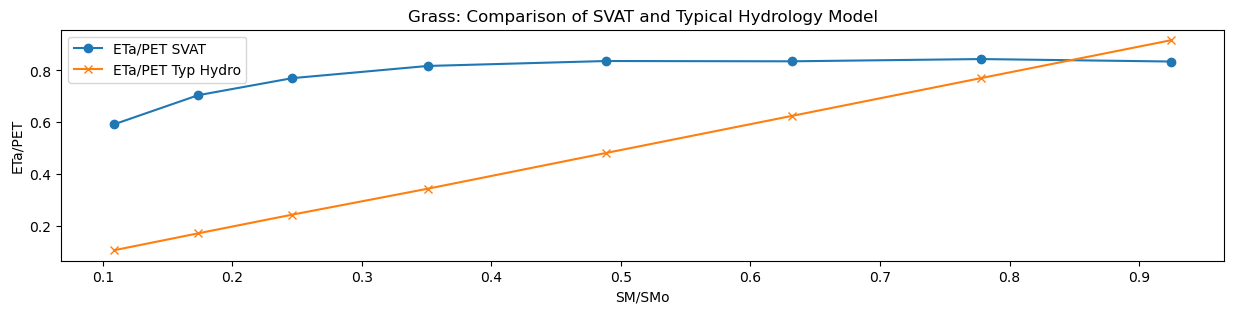

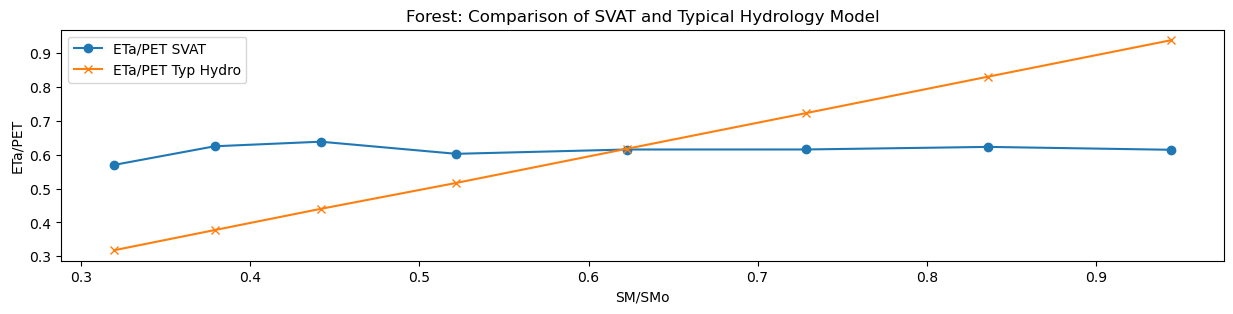

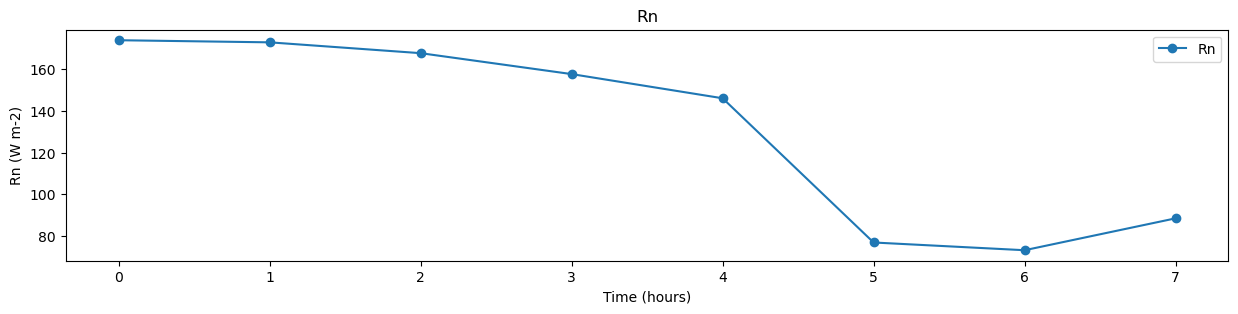

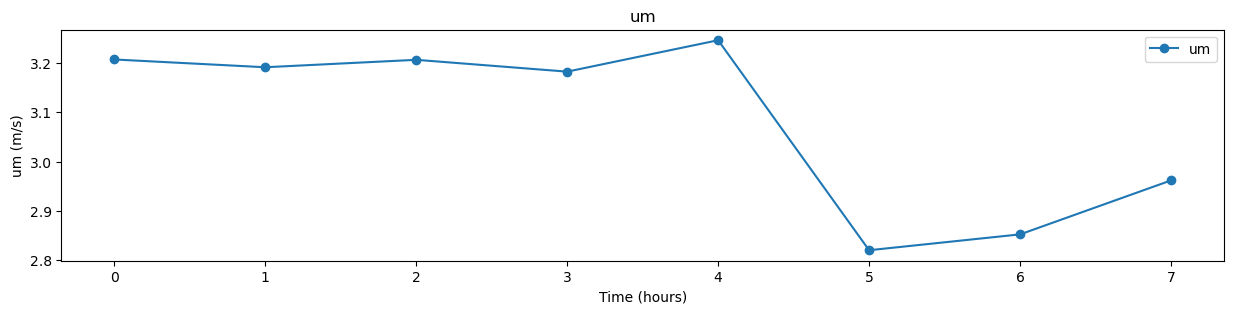

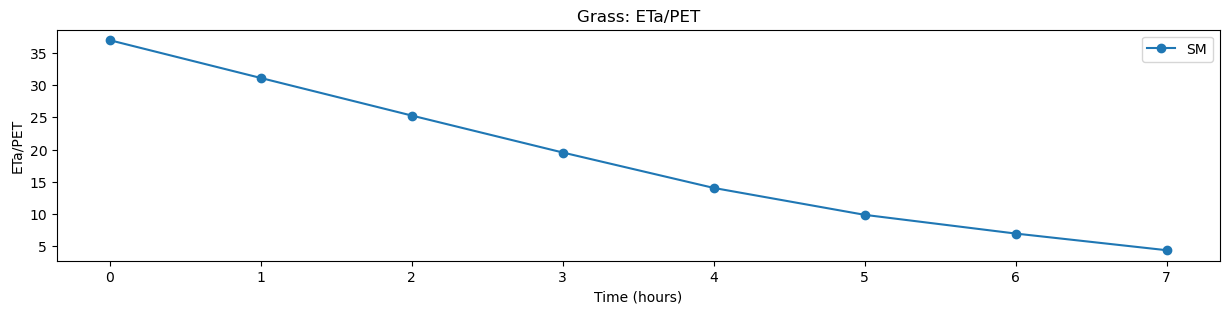

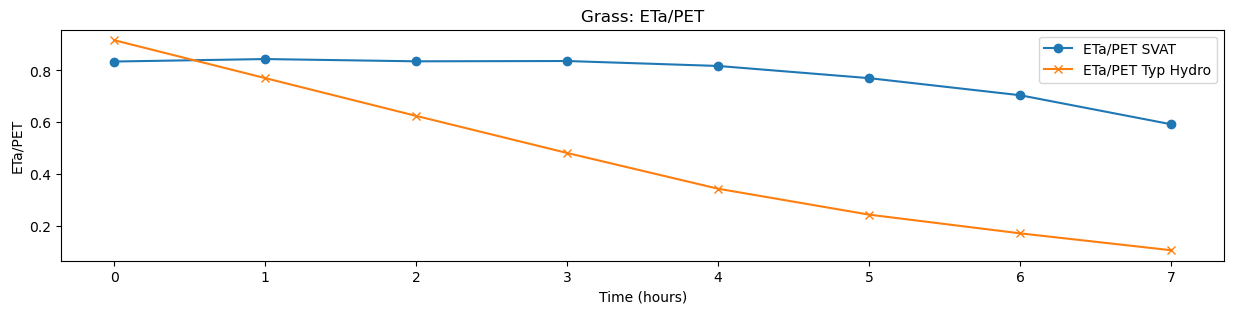

In [591]:
#Plot SM/SMo vs ETa/PET on same graph
fig, ax = plt.subplots(figsize=(15, 3))

# Assuming grass_data is sorted by 'SM/SMo' for meaningful line plots
# Line plot for SVAT
ax.plot(grass_data['SM/SMo'], grass_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')

# Line plot for Typical Hydrology
ax.plot(grass_data['SM/SMo'], grass_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')

ax.set_title('Grass: Comparison of SVAT and Typical Hydrology Model')
ax.set_xlabel('SM/SMo')
ax.set_ylabel('ETa/PET')
ax.legend()

plt.show()

#Plot SM/SMo vs ETa/PET on same graph
fig, ax = plt.subplots(figsize=(15, 3))
# Assuming grass_data is sorted by 'SM/SMo' for meaningful line plots
# Line plot for SVAT
ax.plot(forest_data['SM/SMo'], forest_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')

# Line plot for Typical Hydrology
ax.plot(forest_data['SM/SMo'], forest_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')

ax.set_title('Forest: Comparison of SVAT and Typical Hydrology Model')
ax.set_xlabel('SM/SMo')
ax.set_ylabel('ETa/PET')
ax.legend()

plt.show()

#Plot time on x axis and Rn and ETa/PET on y axis
fig, ax = plt.subplots(figsize=(15, 3))
# Assuming grass_data is sorted by 'Total Hour' for meaningful line plots
# Line plot for Rn
ax.plot(grass_data['Rn'], label='Rn', marker='o')
ax.set_title('Rn')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Rn (W m-2)')
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(15, 3))
# Assuming grass_data is sorted by 'Total Hour' for meaningful line plots
# Line plot for Rn
ax.plot(grass_data['um'], label='um', marker='o')
ax.set_title('um')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('um (m/s)')
ax.legend()
plt.show()

#Plot time on x axis and Rn and ETa/PET on y axis
fig, ax = plt.subplots(figsize=(15, 3))
# Assuming grass_data is sorted by 'Total Hour' for meaningful line plots
# Line plot for ETa/PET
ax.plot(grass_data['SM'], label='SM', marker='o')
ax.set_title('Grass: SM')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('SM (mm)')
ax.legend()
plt.show()


#Plot time on x axis and Rn and ETa/PET on y axis
fig, ax = plt.subplots(figsize=(15, 3))
# Assuming grass_data is sorted by 'Total Hour' for meaningful line plots
# Line plot for ETa/PET
ax.plot(grass_data['ETa/PET SVAT'], label='ETa/PET SVAT', marker='o')
ax.plot(grass_data['ETa/PET Typ Hydro'], label='ETa/PET Typ Hydro', marker='x')
ax.set_title('Grass: ETa/PET')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('ETa/PET')
ax.legend()
plt.show()
